In [1]:
#Gerekli Kütüphanelerin Yüklenmesi
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from datetime import datetime, date
import datetime
import seaborn as sns
import datetime
import warnings
from typing import Optional, List, Dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
#Verinin yüklenmesi
fpath = r'H:\EGITIM\TEZ\Data\dagitilan_data5.xlsx'

df = pd.read_excel(fpath)

df.shape
df.info()
df.head()
df.isnull().sum()

"""
Veri zaman serisi verisinden oluşmakta olup, saatlik tüketilen enerji değerlerini içermektedir. Görüldüğü gibi veri 'tarih', 'dagitilan', 'sicaklik' isimlerinde olan 3 kolondan ve 53.352 satırdan oluşmaktadır ve boş değer içermemektedir.
Kolonlardaki veri formatları datetime64, float64 ve int64'tür.
""" 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44592 entries, 0 to 44591
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   44592 non-null  datetime64[ns]
 1   sicaklik   44592 non-null  int64         
 2   G1         44592 non-null  float64       
 3   TG1        44592 non-null  int64         
 4   G2         44592 non-null  float64       
 5   TG2        44592 non-null  int64         
 6   H1         44592 non-null  float64       
 7   TH1        44592 non-null  int64         
 8   Y1         44592 non-null  float64       
 9   TY1        44592 non-null  int64         
 10  dagitilan  44592 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 3.7 MB


"\nVeri zaman serisi verisinden oluşmakta olup, saatlik tüketilen enerji değerlerini içermektedir. Görüldüğü gibi veri 'tarih', 'dagitilan', 'sicaklik' isimlerinde olan 3 kolondan ve 53.352 satırdan oluşmaktadır ve boş değer içermemektedir.\nKolonlardaki veri formatları datetime64, float64 ve int64'tür.\n"

Q1--> 1175.31737330525
Q3--> 1629.738355025
Q2--> 1423.4263485430001
Q4--> 2253.161139442
IQR--> 454.42098171975
Alt sınır: Q1 - 1.5 * IQR---> 493.68590072562495
Üst sınır: Q3 + 1.5 * IQR---> 2311.369827604625


,datetime,sicaklik,G1,TG1,G2,TG2,H1,TH1,Y1,TY1,dagitilan
2067,2016-03-27 02:59:59.998,3,991.701768,7,1003.032308,8,933.053935,7,936.900419,15,493.685901
38550,2020-05-25 05:59:59.990,11,676.557608,6,726.133615,8,806.896758,16,871.791418,16,630.623783
38551,2020-05-25 06:59:59.990,11,702.874331,9,735.612106,10,838.530176,20,860.565791,20,660.826923
4494,2016-07-06 05:59:59.997,18,829.192761,21,833.668989,22,1035.598102,20,955.090196,17,661.419407
38574,2020-05-26 05:59:59.990,11,630.623783,11,676.557608,6,818.374257,16,931.675571,17,668.652898


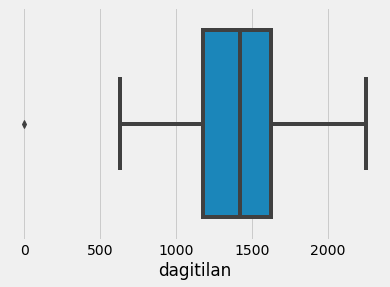

In [3]:
#Aykırı/Uç Değerleri Tespit Etme
df.describe()
sns.boxplot(x=df['dagitilan'])

"""
Veride negatif değerler bulunmaktadır. Ayrıca boxplot grafiği incelenirse; Q1, Q2 ve Q3 değerlerinin sırasıyla 1000-1500, 1500-2000 değerleri arasında hesaplandığı, 
ASD’nin 500'ün altında olduğu ÜSD’nin de 2000'in üzerinde olduğu ve ASD'nin altında değerlerin olduğu görülmektedir.
"""
Q1 = df.dagitilan.quantile(0.25)
Q2 = df.dagitilan.quantile(0.5)
Q3 = df.dagitilan.quantile(0.75)
Q4 = df.dagitilan.quantile(1)
IQR = Q3 - Q1

print("Q1-->", Q1)
print("Q3-->", Q3)
print("Q2-->", Q2)
print("Q4-->", Q4)
print("IQR-->", IQR)
print("Alt sınır: Q1 - 1.5 * IQR--->", Q1 - 1.5 * IQR)
print("Üst sınır: Q3 + 1.5 * IQR--->", Q3 + 1.5 * IQR)

df[df.dagitilan < Q1 - 1.5 * IQR].sort_values('dagitilan')
df.sort_values(['dagitilan'], ascending=True).head(20)

df.loc[(df['dagitilan'] < Q1 - 1.5 * IQR ), 'dagitilan'] = Q1 - 1.5 * IQR
df.sort_values(['dagitilan'], ascending=True).head()

**Verinin Q1, Q2, Q3 değerleri bulunduktan sonra Interquartile range (IQR — Çeyrekler açıklığı) hesaplanır. IQR, birinci çeyrek Q1 ve üçüncü çeyrek Q3 arasındaki uzaklıktır. IQR kullanılarak alt ve üst sınır değerleri aşağıdaki gibi hesaplanır.

IQR = (Q3 – Q1)

Alt Sınır Değer (ASD)= Q1–1.5(IQR)

Üst Sınır Değer (ÜSD)= Q3 + 1.5(IQR)

ASD ve ÜSD dışında kalan tüm değerler outlier (aykırı değer) olarak tespit edilir.

ASD = 487.30 ÜSD = 2275.23

**Grafikte de görüleceği üzere alt sınır değerinin altında olan değerler mevcuttur. Bu değerlere ait günler incelendiğinde 31 Mart 2015 tarihinde Ülke genelinde kesinti olduğu bilgisine ulaşılmıştır. ASD altındaki tüm değerler ASD'ne eşitlenmiştir.

***Index'i değiştirilir ve tarih index olarak atanır.

In [4]:
df = pd.read_excel(fpath, index_col='datetime', parse_dates=['datetime'])
df.head()

,sicaklik,G1,TG1,G2,TG2,H1,TH1,Y1,TY1,dagitilan
datetime,,,,,,,,,,
2015-12-31 23:59:59.998,-2,1206.957762,-2,1204.435576,6,1236.011426,0,936.403640,4,1088.939839
2016-01-01 00:59:59.998,-2,1102.568092,-2,1095.691220,6,1125.353739,-1,865.697698,4,1015.734539
2016-01-01 01:59:59.998,-1,1028.334647,0,1037.698658,6,1061.044480,-1,787.724599,3,927.406615
2016-01-01 02:59:59.998,-1,988.407482,0,1006.341733,6,1022.775691,-1,729.666069,3,864.870040
2016-01-01 03:59:59.998,-1,969.871634,0,993.150922,5,1012.631583,-2,688.746319,4,832.954288


In [5]:
#boş değer kontrolü
df.isna().sum()

sicaklik     0
G1           0
TG1          0
G2           0
TG2          0
H1           0
TH1          0
Y1           0
TY1          0
dagitilan    0
dtype: int64

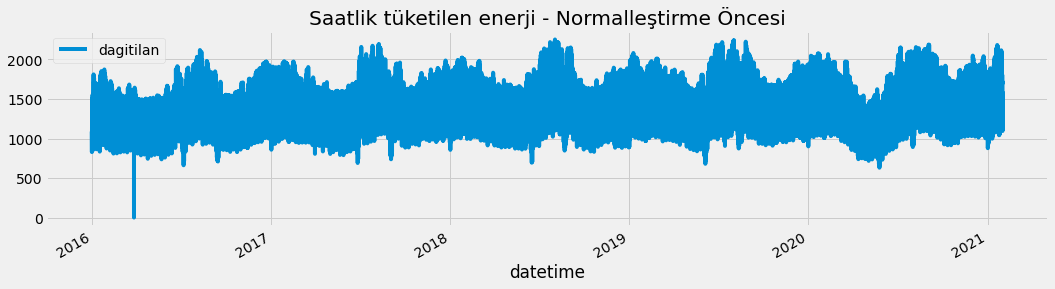

In [6]:
df['dagitilan'].plot(figsize=(16,4),legend=True)

plt.title('Saatlik tüketilen enerji - Normalleştirme Öncesi')

plt.show()

In [7]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['dagitilan'] = scaler.fit_transform(df['dagitilan'].values.reshape(-1,1))
    df['G1'] = scaler.fit_transform(df['G1'].values.reshape(-1,1))
    df['G2'] = scaler.fit_transform(df['G2'].values.reshape(-1,1)) 
    df['H1'] = scaler.fit_transform(df['H1'].values.reshape(-1,1)) 
    df['Y1'] = scaler.fit_transform(df['Y1'].values.reshape(-1,1)) 
    df['sicaklik'] = scaler.fit_transform(df['G1'].values.reshape(-1,1))
    df['TG1'] = scaler.fit_transform(df['G2'].values.reshape(-1,1)) 
    df['TG2'] = scaler.fit_transform(df['H1'].values.reshape(-1,1)) 
    df['TH1'] = scaler.fit_transform(df['Y1'].values.reshape(-1,1))
    df['TY1'] = scaler.fit_transform(df['Y1'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape
df.head()

,sicaklik,G1,TG1,G2,TG2,H1,TH1,Y1,TY1,dagitilan
datetime,,,,,,,,,,
2015-12-31 23:59:59.998,0.535685,0.535685,0.534565,0.534565,0.548579,0.548579,0.417280,0.417280,0.417280,0.483307
2016-01-01 00:59:59.998,0.489356,0.489356,0.486304,0.486304,0.499468,0.499468,0.385990,0.385990,0.385990,0.450818
2016-01-01 01:59:59.998,0.456410,0.456410,0.460566,0.460566,0.470927,0.470927,0.351483,0.351483,0.351483,0.411617
2016-01-01 02:59:59.998,0.438690,0.438690,0.446650,0.446650,0.453943,0.453943,0.325790,0.325790,0.325790,0.383863
2016-01-01 03:59:59.998,0.430464,0.430464,0.440795,0.440795,0.449441,0.449441,0.307681,0.307681,0.307681,0.369699


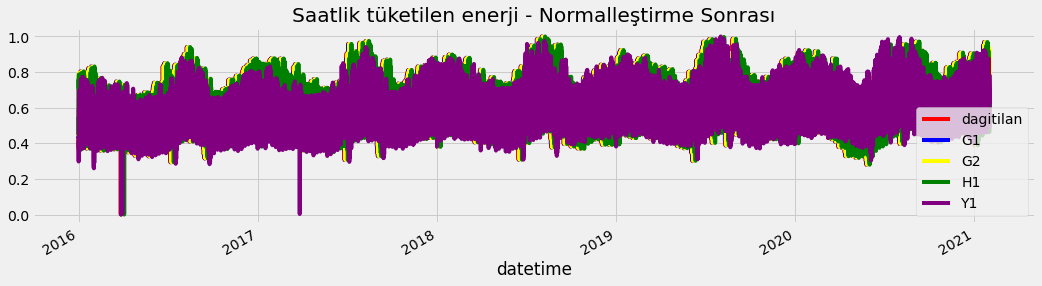

In [8]:
df_norm['dagitilan'].plot(figsize=(16,4), color='red',legend=True)
df_norm['G1'].plot(figsize=(16,4),color='blue',legend=True)
df_norm['G2'].plot(figsize=(16,4),color='yellow',legend=True)
df_norm['H1'].plot(figsize=(16,4),color='green',legend=True)
df_norm['Y1'].plot(figsize=(16,4),color='purple',legend=True)
plt.title('Saatlik tüketilen enerji - Normalleştirme Sonrası')

plt.show()

In [9]:
def load_data(data, seq_len):
    x = []
    y = []
    for i in range(seq_len, len(data)):
        x.append(data.iloc[i-seq_len : i, 0:9])
        y.append(data.iloc[i, -1])
        
#     #Son 4592 adet veri test için kullanılacak.
    x_test = x[40000:]             
    y_test = y[40000:]
        
#     #ilk 50000 adet veri egitimde kullanılacak.
    x_train = x[:40000]           
    y_train = y[:40000]
    
        
    #Numpy dizisine dönüştürülür.
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    #RNN modeli için veri tekrar şekillendirilir.
    x_train = np.reshape(x_train, (np.shape(x_train)[0], seq_len, 9))
    
    x_test = np.reshape(x_test, (np.shape(x_test)[0], seq_len, 9))
    
    return [x_train, y_train, x_test, y_test]

# Son 24 saatin değerlerini kullanarak tüketimin tahmin edilmesi

In [10]:
#Egitim ve test data boyutları
seq_len = 24 #kaç birim zamanlık veri verilecek burada onu belirtiyoruz.

x_train, y_train, x_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (40000, 24, 9)
y_train.shape =  (40000,)
X_test.shape =  (4568, 24, 9)
y_test.shape =  (4568,)


In [11]:
y_testdf = pd.DataFrame(y_test, columns = ['dagitilan'])

# Basit RNN Modeli Kurulması
3 simpleRNN katmanı oluşturulmuştur. ilk katman giriş katmanı 40 çıkışı bulunmaktadır. Kendinden sonraki katmana bağlandığından return_sequences = True değerindedir. Giriş katmanı sonrasında 0.15 lik bir Dropout katmanı koyulmuştur. Dropout en basit ifade ile sistemin ezberlemesini önlemeye çalışan bir katmandır. İkinci katman ve üçüncü katman da simpleRNN katmanıdır ve 40 çıkışı vardır. Onlardan sonra da yine Dropout eklenmiştir. Sonda ise çıkış katmanı olarak normal bir YSA katmanı Dense kullanılmıştır. Bir saatin tüketim tahminini vereceği için çıkışı 1'dir.

input_shape= (nb_samples, timesteps, input_dim), imput_dim = tek bir sayısal değerin değişimi var ise giriş veri boyutu 1 dir.

LSTM ler genel anlamda sequence zaman sıralı şekilde gelen veriler üzerinden çalışırlar. keras.layers.recurrent.LSTM(output_dim, batch_input_shape=(nb_samples, timesteps, input_dim), return_sequences=False,....) (eğer LSTM ilk katmansa batch_input_shape verilmesi gerekiyor.)

nb_samples : veri sayısıdır, None verilebilir. timesteps : LSTM e verilecek veriler zaman bazında değişen aynı türdeki verilerdir ve kaç birim zamanlık veri verilecek ise burada o belirtilmelidir. input_dim : giriş verisinin boyutudur. return_sequences : Kendinden sonraki katman Yine Bir LSTM olacaksa True yazılmalıdır. output_dim : Katman çıkış boyutu ve LSTM birim sayısıdır. Ağın çıkışı , eğer kendinden sonraki katman Yine Bir LSTM olacaksa (nb_samples, timesteps, output_dim), olmayacaksa (nb_samples, , output_dim) olur.

parametre sayısı = (m * n + n^2 + n)

m = giriş parametre sayısı

n = çıkış parametre sayısı

katman : ( 9x40 + 40^2 + 40 = 2000 )
ve 3. katman : ( 40x40 + 40^2 + 40 = 3240 ) Çıkış katmanı ( 40 ağırlık + 1 bias = 41 )

In [12]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],9)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))  
 
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 40)            2000      
                                                                 
 dropout (Dropout)           (None, 24, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 24, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

Birden fazla girdinin parçalar halinde işlenmesi “mini-batch” olarak adlandırılmaktadır. Model tasarlanırken mini-batch parametresi olarak belirlenen değer; modelin aynı anda kaç veriyi işleyeceği anlamına gelmektedir.

Mutlak minimim değerinin bulunması için: Yapay sinir ağlarının optimizasyonu için en çok kullanılan yöntemlerden biri gradyan inişidir (Gradient descent). Gradyan inişi yöntemini esas alan çeşitli algoritmalar : Rmsprop, Adagrad, Adam, Nadam

In [13]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(x_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 6s 94ms/step - loss: 0.1985
Epoch 2/10
40/40 [==============================] - 4s 94ms/step - loss: 0.0915
Epoch 3/10
40/40 [==============================] - 4s 97ms/step - loss: 0.0468
Epoch 4/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0308
Epoch 5/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0237
Epoch 6/10
40/40 [==============================] - 4s 96ms/step - loss: 0.0193
Epoch 7/10
40/40 [==============================] - 4s 96ms/step - loss: 0.0167
Epoch 8/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0145
Epoch 9/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0127
Epoch 10/10
40/40 [==============================] - 4s 93ms/step - loss: 0.0117


In [14]:
rnn_predictions = rnn_model.predict(x_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

143/143 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.837885789154058


evaluate(), önceden eğitilmiş modeli değerlendirmek içindir. Model için kayıp değerini ve ölçüm değerlerini döndürür.

In [15]:
trainScore = rnn_model.evaluate(x_train, y_train, batch_size = 1000, verbose = 0)
print('Train Score : ', trainScore)
testScore = rnn_model.evaluate(x_test[:252], y_test[:252], batch_size = 1000, verbose = 0)
print('Test Score : ', testScore)

Train Score :  0.002815851243212819
Test Score :  0.0065847476944327354


In [16]:
y_predictions_rnn = pd.DataFrame(rnn_predictions, columns = ['dagitilan'])

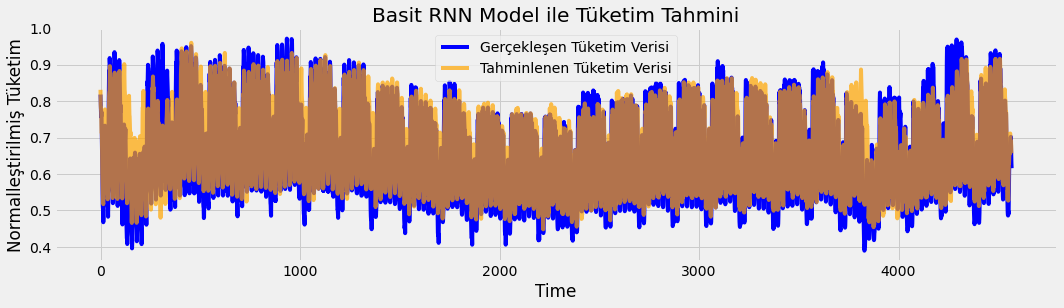

In [17]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Gerçekleşen Tüketim Verisi')
    plt.plot(predicted, alpha=0.7, color='orange',label='Tahminlenen Tüketim Verisi')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalleştirilmiş Tüketim')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Basit RNN Model ile Tüketim Tahmini")

# LSTM Katmanı kurulması
Geleneksel RNN’lerde, tekrarlayan kısımda tek bir tanjant fonksiyonu (katmanı) bulunmaktadır. LSTM’lerde ise tek bir sinir katmanı yerine tekrarlayan zincir şeklinde dört farklı katman bulunmaktadır. Bu nedenle; parametre sayısı = 4 (m n + n^2 + n) m = giriş parametre sayısı n = çıkış parametre sayısı

katman : 4 ( 9x40 + 40^2 + 40 = 8000 )
ve 3. katman : 4 ( 40x40 + 40^2 + 40 = 12960 ) Çıkış katmanı ( 40 ağırlık + 1 bias = 41 )

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],9)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 40)            8000      
                                                                 
 dropout_3 (Dropout)         (None, 24, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 24, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [19]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(x_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 15s 239ms/step - loss: 0.0467
Epoch 2/10
40/40 [==============================] - 9s 235ms/step - loss: 0.0211
Epoch 3/10
40/40 [==============================] - 9s 235ms/step - loss: 0.0191
Epoch 4/10
40/40 [==============================] - 9s 230ms/step - loss: 0.0176
Epoch 5/10
40/40 [==============================] - 8s 213ms/step - loss: 0.0151
Epoch 6/10
40/40 [==============================] - 9s 214ms/step - loss: 0.0112
Epoch 7/10
40/40 [==============================] - 9s 217ms/step - loss: 0.0097
Epoch 8/10
40/40 [==============================] - 9s 222ms/step - loss: 0.0088
Epoch 9/10
40/40 [==============================] - 9s 218ms/step - loss: 0.0082
Epoch 10/10
40/40 [==============================] - 9s 214ms/step - loss: 0.0077


In [20]:
lstm_predictions = lstm_model.predict(x_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

143/143 [==============================] - 3s 8ms/step
R^2 Score of LSTM model =  0.744139749307055


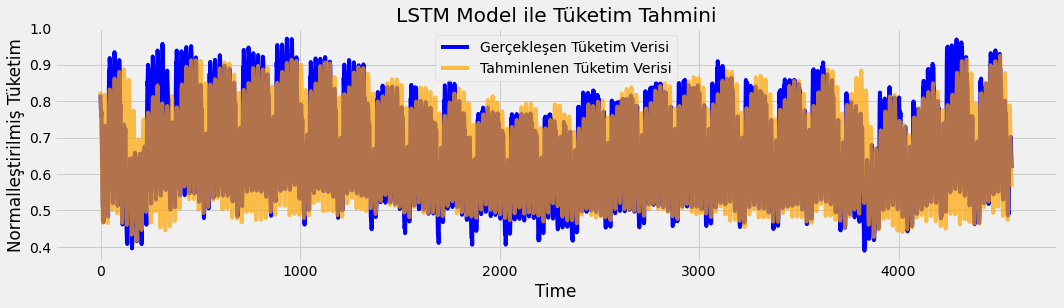

In [21]:
plot_predictions(y_test, lstm_predictions, "LSTM Model ile Tüketim Tahmini")


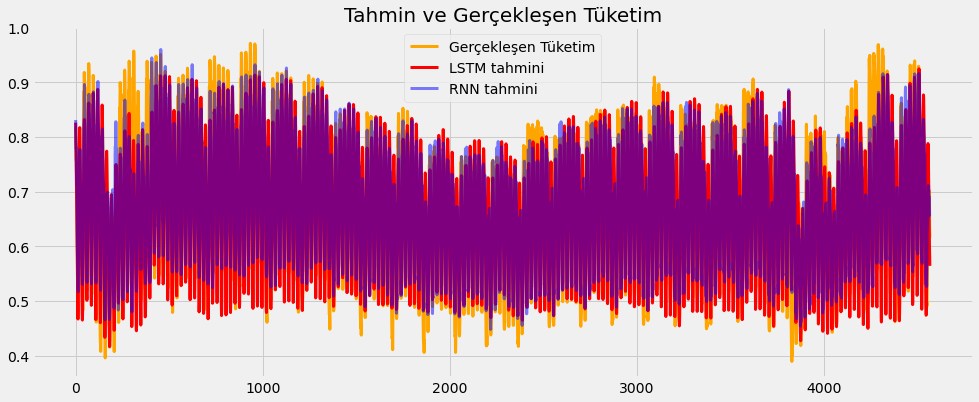

In [22]:
plt.figure(figsize=(15,6))

plt.plot(y_test, c="orange", linewidth=3, label="Gerçekleşen Tüketim")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM tahmini")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN tahmini")
plt.legend()
plt.title("Tahmin ve Gerçekleşen Tüketim", fontsize=20)
plt.show()

In [23]:
y_predictions_lstm = pd.DataFrame(lstm_predictions, columns = ['dagitilan'])

# Model değerlendirme
Aşağıdaki metrikleri kullanarak zaman serisi tahmin modellerinin performansını değerlendirilir. 

*ortalama mutlak hata (MAE), ortalama karesel hata (RMSE), ortalama mutlak yüzde hatası (MAPE)

In [24]:
def evaluate_forecast_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    mape_cutoff: int = 100,
) -> Dict:
 
    # Ortalama Mutlak Hata  (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Ortalama Kare Hata  (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Ortalama Mutlak Yüzde Hata  (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    return {"MAE":round(mae, 3),
            "RMSE":round(rmse, 3),
            "MAPE":round(mape, 3)}
        

In [25]:
rnn_metrics = evaluate_forecast_metrics(y_testdf['dagitilan'], y_predictions_rnn["dagitilan"])
print("RNN evaluate forecast metrics = ", rnn_metrics)
lstm_metrics = evaluate_forecast_metrics(y_testdf['dagitilan'], y_predictions_lstm["dagitilan"])
print("LSTM evaluate forecast metrics = ", lstm_metrics)

RNN evaluate forecast metrics =  {'MAE': 0.04, 'RMSE': 0.053, 'MAPE': 6.268}
LSTM evaluate forecast metrics =  {'MAE': 0.051, 'RMSE': 0.067, 'MAPE': 7.699}


In [26]:
rnn_predictions = rnn_model.predict(x_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)
   
lstm_predictions = lstm_model.predict(x_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score of LSTM model = ",lstm_score)

143/143 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.837885789154058
143/143 [==============================] - 1s 8ms/step
R2 Score of LSTM model =  0.744139749307055
